Set up Colab requirements if in Colab, or autoreload if in jupyter

In [1]:
try: # test if running from colab
    import google.colab
    in_colab = True
except:
    in_colab = False

if in_colab:
    %cd /content
    !rm -rf gps-lane-changes
    !git clone https://github.com/tomdries/gps-lane-changes
    %cd gps-lane-changes
else:
    %load_ext autoreload 
    %autoreload 2
    

In [2]:
import pandas as pd
from pathlib import Path
import dataloaders
import matplotlib.pyplot as plt
import numpy as np
from analysis_helpers import *
from calculate_offset import angular_diff
import seaborn as sns

sns.set_style('white')


In [98]:
lca_dfs, trip_dfs, trip_names, road_dfs = dataloaders.load_data()

As direction calculation can get quite noisy at low speeds, we remove driving under 30 km/h. 

# Calculate offset and append to all dataframes
The output of the current cell is already stored and loaded - leave commented out

In [4]:
# from calculate_offset import batch_append_offset
# trip_dfs_out = batch_append_offset(trip_dfs, trip_names, road_dfs, save_path=None)

# Create labeled time windows

Select trip and device

<img src="figures/sections.jpg" width=200 height=300 />

Calculate signals

# Calculate detection

Metrics:

Hit (True Positive): A lane change was detected (in the correct direction) at most half a detection window before and after a lane change annotation (ground truth).  
Miss (False Negative): A lane change was annotated but no detection signal was found W/2 before and after 

In [36]:
result_df = pd.DataFrame(columns = ['trip_nr','dev_nr', 'sections', 'trip_name', 'signal_name', 'ROLLING_SUM_SIZE', 'CUTOFF_THRESHOLD', 'precision', 'recall', 'f1'])


In [37]:
# Detection signal
def calculate_detection_signals(trip_df, signal_name, ROLLING_SUM_SIZE,CUTOFF_THRESHOLD):
    trip_df['detection_right'] = (trip_df[signal_name].rolling(ROLLING_SUM_SIZE).sum()>CUTOFF_THRESHOLD).astype(int).diff()
    trip_df['detection_left'] =  (trip_df[signal_name].rolling(ROLLING_SUM_SIZE).sum()<-CUTOFF_THRESHOLD).astype(int).diff()

    trip_df['detection'] = (trip_df['detection_right']==1)*1 - (trip_df['detection_left']==1)*1
    trip_df['detection'] = trip_df['detection'].replace([-1, 0, 1],['left', 'none', 'right'])
    return trip_df
    
def get_results(lca_df, trip_df, LANE_CHANGE_DURATION):

    lca_df['detected'] = ['none']*len(lca_df)

    for ix_row, lca_row in lca_df.iterrows():
            detection_window = trip_df[trip_df.t.between(lca_row.t_start_approx, lca_row.t_end_approx)]
            if 1 in list(detection_window.detection_right): #
                lca_df.loc[ix_row,'detected']='right'
            if 1 in list(detection_window.detection_left):
                lca_df.loc[ix_row,'detected']='left'

    lca_df.loc[lca_df.direction == lca_df.detected, 'result'] = 'TP' 
    lca_df.loc[lca_df.detected=='none', 'result'] = 'FN'
    TP = lca_df.result.value_counts()['TP']
    FN = lca_df.result.value_counts()['FN']

    ## false positives
    TP_detectionperspective = 0
    FP = 0

    for direction in ['left', 'right']:
        for t_detection in trip_df[trip_df[f'detection_{direction}']==1].t:
            lowerbound = t_detection - LANE_CHANGE_DURATION / 2
            upperbound = t_detection + LANE_CHANGE_DURATION / 2
            lane_changes_found = lca_df[lca_df.t_lc.between(lowerbound, upperbound)]
            if len(lane_changes_found) > 0:
                if lane_changes_found.direction.iloc[0] == direction:
                    TP_detectionperspective +=1
                else: 
                    FP +=1
            else: 
                FP+=1
                
    precision, recall, f1 = precision_recall_f1(TP,FN,FP)
    return TP, TP_detectionperspective, FP, FN, precision, recall, f1



In [99]:
filter_params = {'EWM_SPAN': 3,
                 'MEDFILT_SIZE': 4,
                 'PROJ_DIST_ROLLINGSUM': 3}

trip_dfs = calculate_signals_alltrips(trip_dfs, filter_params)

In [85]:


dev_nr = 1
trip_nr = 0
sections = 'all'
LANE_CHANGE_DURATION = 8 

tp_total=0
fp_total=0
fn_total=0

for trip_nr in range(3):
    trip_df, lca_df, trip_name = selector(trip_dfs,lca_dfs, trip_names, trip_nr, dev_nr, sections = sections, road_type='all')

    lca_df['t_start_approx'] = lca_df['t_lc'] - LANE_CHANGE_DURATION/2
    lca_df['t_end_approx'] = lca_df['t_lc']  + LANE_CHANGE_DURATION/2

    signal_name = 'proj_lat_dist_ewmfilt'

    ROLLING_SUM_SIZE = 5
    CUTOFF_THRESHOLD= 1.5
    trip_df = calculate_detection_signals(trip_df, signal_name, ROLLING_SUM_SIZE,CUTOFF_THRESHOLD)
    tp, tp2, fp, fn, precision, recall, f1 = get_results(lca_df,trip_df, LANE_CHANGE_DURATION)
    tp_total+=tp
    fp_total+=fp
    fn_total+=fn
    result_df.loc[len(result_df)] = [trip_nr, dev_nr, sections, trip_name, signal_name, ROLLING_SUM_SIZE, CUTOFF_THRESHOLD, precision, recall, f1]
    


In [89]:
precision_recall_f1(tp_total, fn_total, fp_total)

(0.5603715170278638, 0.8916256157635468, 0.688212927756654)

In [103]:
lookback_offset = [np.nan]*len(trip_df)
col = 'offset'
LOOKBACK=5
for i in range(len(trip_df)-LOOKBACK):
    under = trip_df[col].iloc[i]
    upper = trip_df[col].iloc[i+LOOKBACK]
    lookback_offset[i+LOOKBACK]=upper-under
trip_df['lookback_offset'] = lookback_offset
    
trip_df[['offset', 'lookback_offset']][:30]

,offset,lookback_offset
0,0.132243,NaN
1,-0.183052,NaN
2,-0.037167,NaN
3,0.202436,NaN
4,0.673799,NaN
5,0.878813,0.746570
6,1.323099,1.506151
7,1.596005,1.633172
8,1.664910,1.462474
9,1.562110,0.888311


In [ ]:
trip_df

Plot detections

(2200.0, 2300.0)

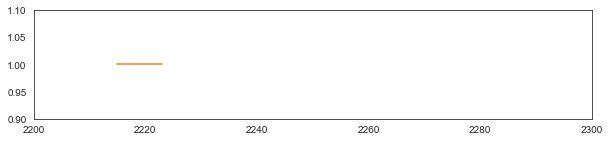

In [102]:
fig, ax = plt.subplots(figsize=(10,2))


# plt.plot(trip_df.t, trip_df.detection_left, linestyle = 'None', marker='x', markersize=12, mew=2)
# plt.plot(trip_df.t, trip_df.detection_right, linestyle='None', marker='x', markersize=12, mew=2)

for _, row in lca_df.iterrows(): 
    color = ('C0' if row.direction=='left' else 'C1')
    plt.plot([row.t_start_approx, row.t_end_approx], [1, 1], c=color)

plt.ylim(0.9,1.1)
plt.xlim(2200,2300)
# plot_lane_changes(lca_dfs[trip_nr])



In [25]:
lca_df

,time start,time middle,from lane,to lane,total lanes,type,direction,multiple lanes,t_lc,frame_number,section,road type,t_start_approx,t_end_approx
0,NaN,00.03.28.089,3,2,4,NaN,left,False,208.089,6236,A,straight,204.089,212.089
1,NaN,00.03.54.545,2,3,3,NaN,right,False,234.545,7029,A,straight,230.545,238.545
2,NaN,00.04.08.921,3,2,3,NaN,left,False,248.921,7460,A,straight,244.921,252.921
3,NaN,00.04.34.390,2,3,3,NaN,right,False,274.390,8223,A,straight,270.390,278.390
4,NaN,00.04.47.672,3,2,3,NaN,left,False,287.672,8622,A,straight,283.672,291.672
5,NaN,00.05.07.807,2,3,3,NaN,right,False,307.807,9225,A,straight,303.807,311.807
6,NaN,00.05.31.851,3,2,3,NaN,left,False,331.851,9946,A,straight,327.851,335.851
7,NaN,00.05.53.236,2,3,3,NaN,right,False,353.236,10586,A,straight,349.236,357.236
8,NaN,00.05.59.639,3,2,4,NaN,left,False,359.639,10778,A,straight,355.639,363.639
9,NaN,00.06.52.610,2,3,3,NaN,right,False,412.610,12366,A,straight,408.610,416.610


# Rolling window evaluation

In [174]:
# sliding window based evaluation
t0_w = trip_df.t.iloc[0]-.1 #t0 window
te_w = t0_w + LANE_CHANGE_DURATION-.1 #t_end_window
total_duration = int(trip_df.t.iloc[-1]-trip_df.t.iloc[0])+1

t_window = [np.nan]*total_duration
window_labels = [np.nan]*total_duration
window_truths = [np.nan]*total_duration

for i in range(total_duration):
    
    window = list(trip_df[trip_df.t.between(t0_w, te_w)].detection.dropna())
    if 'left' in window:
        window_label = 'left'
    elif 'right' in window:
        window_label = 'right'
    else:
        window_label = 'none'
        
    
    window_truth_df = lca_df[lca_df.t_lc.between(t0_w, te_w)]
    if len(window_truth_df) == 0:
        window_truth = 'none'
    else:
        window_truth = window_truth_df.direction.iloc[0]
    
    t_window[i] = te_w+.1
    window_labels[i] = window_label
    window_truths[i] = window_truth
        
    t0_w += 1
    te_w += 1

df = pd.DataFrame({'t': t_window, 'window_label': window_labels, 'window_truth': window_truths})
df.loc[(df.window_label=='right')&(df.window_truth=='right'),'result'] = 'TP'
df.loc[(df.window_label=='left')&(df.window_truth=='left'),'result'] = 'TP'
df.loc[(df.window_label=='none')&(df.window_truth=='none'),'result'] = 'TN'
df.loc[(df.window_label!='none')&(df.window_truth=='none'), 'result'] = 'FP'
df.loc[(df.window_label=='none')&(df.window_truth!='none'), 'result'] = 'FN'
results = df.result.value_counts()


In [175]:
precision_recall_f1(results.TP,results.FN,results.FP)

(0.5916149068322981, 0.639261744966443, 0.614516129032258)

In [ ]:
trip_df[trip_df.t.between(470,490)].detection_left

# plotting lane changes

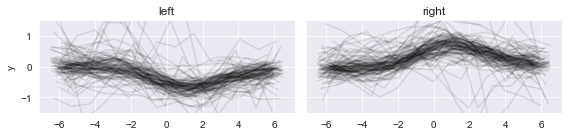

In [ ]:
sns.set_style('darkgrid')
device_nr = 1
sections = 'all'

window_size=13
fragments = extract_lanechange_fragments_alltrips(trip_dfs, trip_names, lca_dfs, device_nr, sections, window_size)

params = {'ylims': (-1.5,1.5),
         'alpha': 0.1,
         'ylabel': 'y'}

plot_col = 'lat_vel_ewmfilt'
plot_fragments(fragments, plot_col, params)

# plt.savefig('figures/lanechanges.png', dpi=600, bbox_inches='tight')


## To Do: Add n to plot above. Make one for A13 and one for Ring Rotterdam

In [7]:
for i_trip, lca_df in enumerate(lca_dfs):
    for direction in ['left', 'right']:
        min_t_diff = lca_df[lca_df.direction==direction].t_lc.diff().min()
        print("trip", i_trip, direction, "min_t_diff", min_t_diff)
       
    


trip 0 left min_t_diff 6.373000000000047
trip 0 right min_t_diff 4.0770000000002256
trip 1 left min_t_diff 5.579000000000065
trip 1 right min_t_diff 5.108999999999924
trip 2 left min_t_diff 5.956999999999994
trip 2 right min_t_diff 5.760999999999967
